In [1]:
import pennylane as qml
import random
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('../')

In [2]:
device = 'cpu'

In [3]:
date = '20211007_120838'

resume_iters = 120

test_sample_size = 10000

z_dim = 8

In [4]:
model_dir_path = r'/home/ken/projects/QuantumGAN-PyTorch/results/GAN/'+date+'/train/model_dir'

In [5]:
def sample_z(batch_size):
    return np.random.normal(0, 1, size=(batch_size, z_dim))

In [6]:
z = sample_z(test_sample_size)

In [7]:
corr_matrix = np.corrcoef(z).round(decimals=2)

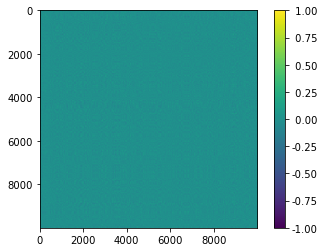

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix)
im.set_clim(-1, 1)
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
ax.grid(False)
plt.show()


# Data

In [9]:
from data.sparse_molecular_dataset import SparseMolecularDataset

In [10]:
mol_data_dir = 'data/gdb9_9nodes.sparsedataset'

In [11]:
data = SparseMolecularDataset()

data.load(mol_data_dir)

# Generator

In [12]:
from models.models import Generator, Discriminator

In [13]:
complexity = 'mr'

dropout = 0.0

In [14]:
if complexity == 'nr':
    g_conv_dim = [128, 256, 512]
elif complexity == 'mr':
    g_conv_dim = [128]
elif complexity == 'hr':
    g_conv_dim = [16]
else:
    raise ValueError("Please enter an valid model complexity from 'mr', 'hr' or 'nr'!")

In [15]:
G = Generator(g_conv_dim, z_dim, data.vertexes, data.bond_num_types, data.atom_num_types, dropout)

In [16]:
G.to(device)

Generator(
  (activation_f): Tanh()
  (multi_dense_layers): MultiDenseLayers(
    (activation): Tanh()
    (linear_layers): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.0, inplace=False)
    )
  )
  (edges_layer): Linear(in_features=128, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=128, out_features=45, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [17]:
G_path = os.path.join(model_dir_path, '{}-G.ckpt'.format(resume_iters))

In [18]:
G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))

<All keys matched successfully>

# Generating Molecules

In [19]:
import torch.nn.functional as F

In [20]:
z = torch.from_numpy(z).to(device).float()

In [21]:
post_method = 'softmax'

In [22]:
edges_logits, nodes_logits = G(z)

In [23]:
def postprocess(inputs, method, temperature=1.0):
    def listify(x):
        return x if type(x) == list or type(x) == tuple else [x]
    def delistify(x):
        return x if len(x) > 1 else x[0]
    if method == 'soft_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))/temperature, hard=False).view(e_logits.size()) for e_logits in listify(inputs)]
    elif method == 'hard_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))/temperature, hard=True).view(e_logits.size()) for e_logits in listify(inputs)]
    else:
        softmax = [F.softmax(e_logits/temperature, -1) for e_logits in listify(inputs)]
    return [delistify(e) for e in (softmax)]

In [24]:
(edges_hat, nodes_hat) = postprocess((edges_logits, nodes_logits), post_method)   

edges_hat_numpy = edges_hat.cpu().detach().numpy()
nodes_hat_numpy = nodes_hat.cpu().detach().numpy()
np.save("edges_hat.npy", edges_hat_numpy)
np.save("nodes_hat.npy", nodes_hat_numpy)

In [25]:
def get_gen_mols(data, n_hat, e_hat, method):
    (edges_hard, nodes_hard) = postprocess((e_hat, n_hat), method)
    edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
    mols = [data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True) for e_, n_ in zip(edges_hard, nodes_hard)]
    return mols

In [26]:
mols = get_gen_mols(data, nodes_logits, edges_logits, post_method)

RDKit ERROR: [19:21:36] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:21:36] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6

RDKit ERROR: [19:21:36] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:36] Explicit valence for atom # 8 C, 5, is greater than permitted
[19:21:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:21:36] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6

RDKit ERROR: [19:21:36] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [19:21:36] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [19:21:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:21:36] Explicit valence for atom # 8 C, 5, is greater than permitted
[19:21:36] Explicit valence for atom # 2 O, 3, is greater than permitted
[19:21:36] Explicit valence for atom # 0 N, 4, is g

RDKit ERROR: [19:21:36] Can't kekulize mol.  Unkekulized atoms: 3 5 6
[19:21:36] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:21:36] Explicit valence for atom # 8 O, 3, is greater than permitted
[19:21:36] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6

[19:21:36] non-ring atom 1 marked aromatic
[19:21:36] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:21:36] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6

[19:21:36] Explicit valence for atom # 2 O, 4, is greater than permitted
[19:21:36] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:21:36] Can't kekulize mol.  Unkekulized atoms: 3 4 6

[19:21:36] non-ring atom 1 marked aromatic
RDKit ERROR: 
[19:21:36] Can't kekulize mol.  Unkekulized atoms: 3 5 6

RDKit ERROR: [19:21:36] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [19:21:36] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [19:21:36] Explicit valence for atom # 0

[19:21:36] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6

[19:21:36] Explicit valence for atom # 7 C, 6, is greater than permitted
[19:21:36] non-ring atom 3 marked aromatic
[19:21:36] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:21:36] non-ring atom 1 marked aromatic
RDKit ERROR: [19:21:36] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [19:21:36] Can't kekulize mol.  Unkekulized atoms: 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:36] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:36] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:36] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [19:21:36] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [19:21:36] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:36] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [19

[19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4

[19:21:37] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6

[19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 5

[19:21:37] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:37] Explicit valence for atom # 7 O, 3, is greater than permitted
[19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6

[19:21:37] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [19:21:37] Explicit valence for atom # 6 O, 3, is greater than permitted
[19:21:37] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 3 6
RDKit ERROR: 
[19:21:37] Can't kekulize mol.  Unkekulized atoms: 3 6

RDKit ERROR: [19:21:37] Explicit valence for atom # 1 C, 5, is greater

RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4
[19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4

RDKit ERROR: 
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:37] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4
RDKit ERROR: 
RDKit ERROR: [19:21:37] non-ring atom 3 marked aromatic
RDKit ERROR: [19:21:37] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [19:21:37] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:37] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [19:21:37] Ex

RDKit ERROR: [19:21:37] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [19:21:37] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [19:21:37] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [19:21:37] non-ring atom 1 marked aromatic
RDKit ERROR: [19:21:37] Explicit valence for atom # 5 O, 4, is greater than permitted
RDKit ERROR: [19:21:37] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [19:21:37] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:37] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 4 5
RDKit ERROR: 
RDKit ERROR: [19:21:37] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERRO

RDKit ERROR: 
RDKit ERROR: [19:21:37] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1
RDKit ERROR: 
RDKit ERROR: [19:21:37] Explicit valence for atom # 6 O, 3, is greater than permitted
[19:21:37] non-ring atom 3 marked aromatic
[19:21:37] non-ring atom 7 marked aromatic
[19:21:37] Can't kekulize mol.  Unkekulized atoms: 3 5 6

[19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6

[19:21:37] Explicit valence for atom # 2 O, 3, is greater than permitted
[19:21:37] Can't kekulize mol.  Unkekulized atoms: 1

[19:21:37] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [19:21:37] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [19:21:37] non-ring atom 1 marked aromatic
RDKit ERROR: [19:21:37] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [19:21:37] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [

[19:21:37] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:21:37] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:21:37] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [19:21:37] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:37] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:21:37] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:21:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6

[19:21:37] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [19:21:38] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:21:38] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [19:21:38] Can't kekulize mol.  Unkekulized atoms: 3 4 5
RDKit ERROR: 
RDKit ERROR: [19:21:38] Explicit valence for atom # 1 F, 6, is greater

[19:21:38] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [19:21:38] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [19:21:38] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [19:21:38] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [19:21:38] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [19:21:38] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 
RDKit ERROR: [19:21:38] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [19:21:38] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [19:21:38] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [19:21:38] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [19:21:38] non-ring atom 1 marked aromatic
RDKit ERROR: [19:21:38] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [1

# Scores

In [27]:
from utils.utils import *

In [28]:
m0, m1 = all_scores(mols, data, norm=True)

In [29]:
from collections import defaultdict

scores = defaultdict(list)

for k, v in m1.items():
    scores[k].append(v)
for k, v in m0.items():
    scores[k].append(np.array(v)[np.nonzero(v)].mean())

In [30]:
scores

defaultdict(list,
            {'valid': [78.03999781608582],
             'unique': [76.46078933880062],
             'novel': [64.67196309584828],
             'NP': [0.9285280254642082],
             'QED': [0.4695608065584007],
             'Solute': [0.305382272680678],
             'SA': [0.29964463743473096],
             'diverse': [0.6177106335406144],
             'drugcand': [0.40144532894406937]})

In [31]:
benchmarking_scores = ['NP', 'QED', 'Solute', 'SA', 'drugcand']

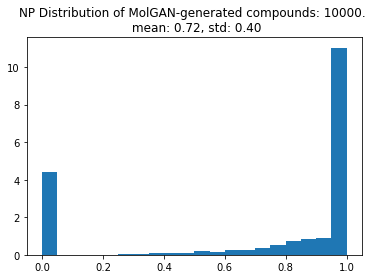

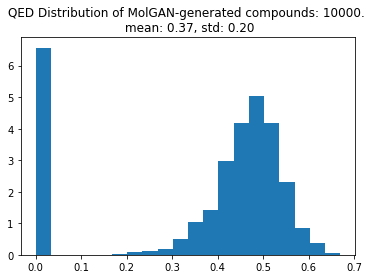

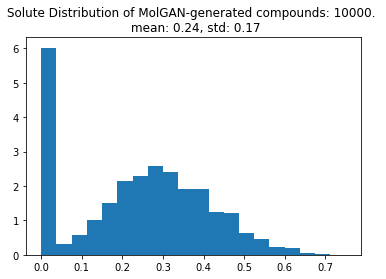

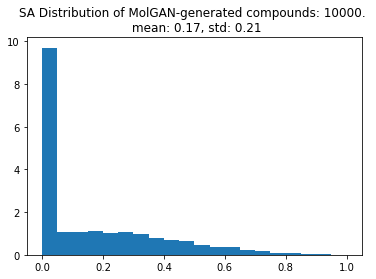

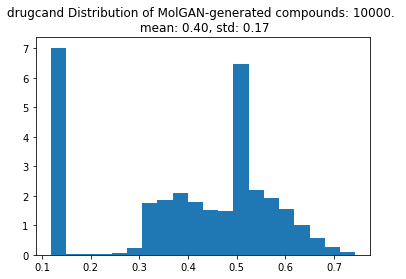

In [32]:
for idx, score in enumerate(benchmarking_scores):
    mols_score = m0[score]
    mols_score_avg = sum(mols_score)/len(mols_score)
    mols_score_std = np.std(mols_score)
    plt.figure(idx)
    plt.hist(mols_score, bins=20, density=True)
    plt.title(score + ' Distribution of MolGAN-generated compounds: {}. \n mean: {:.2f}, std: {:.2f}'.format(len(mols_score), mols_score_avg, mols_score_std))

# Unique Molecules Scores

In [33]:
v = MolecularMetrics.valid_filter(mols)

In [34]:
s = set(map(lambda x: Chem.MolToSmiles(x), v))

In [35]:
unique_mols = list(map(lambda x: Chem.MolFromSmiles(x), s))

In [36]:
unique_valid_mols = MolecularMetrics.valid_filter(unique_mols)

In [37]:
len(unique_valid_mols)

5967

In [38]:
from rdkit.Chem import Draw

img=Draw.MolsToGridImage(unique_valid_mols,molsPerRow=8,subImgSize=(200,200), maxMols=500)    

/home/ken/anaconda3/envs/molgan-pt/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 500. Change the maxMols value to display more.
  % (maxMols))


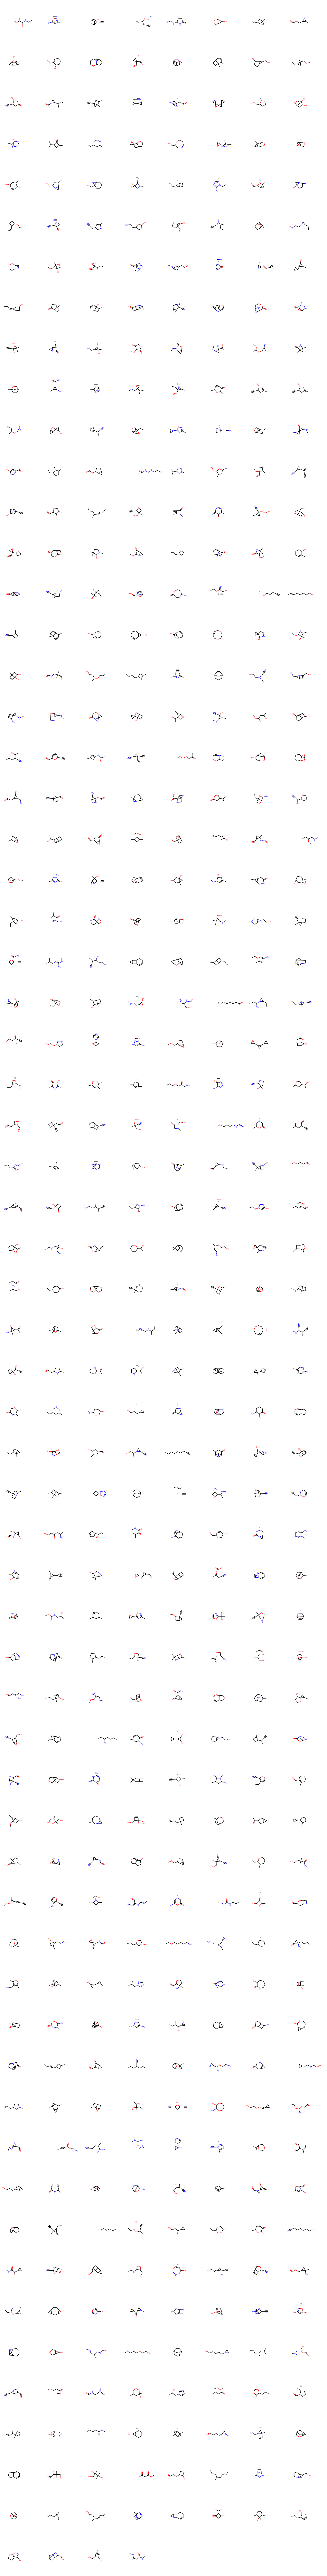

In [39]:
img

df = pd.DataFrame({'SMILES': data} for data in s)

df.to_csv('molgan-'+str(resume_iters)+'.csv', index=False)

In [40]:
from collections import defaultdict

m0, m1 = all_scores(unique_valid_mols, data, norm=True)

new_scores = defaultdict(list)

for k, v in m1.items():
    new_scores[k].append(v)
for k, v in m0.items():
    new_scores[k].append(np.array(v)[np.nonzero(v)].mean())

In [41]:
new_scores

defaultdict(list,
            {'valid': [100.0],
             'unique': [100.0],
             'novel': [68.71124518183342],
             'NP': [0.9264910247252073],
             'QED': [0.4694024249577687],
             'Solute': [0.3032602871753285],
             'SA': [0.30610870553019043],
             'diverse': [0.7646890004249937],
             'drugcand': [0.4880445012829246]})